In [1]:
"""
Created on 2/11/19

@author: ivanchen

"""
"""
Created on 2/6/19

@author: ivanchen

"""
import sys
#sys.path.append("~/.conda/envs/lightfm/lib/python3.6/site-packages")
#sys.path.append('/nfs/home/lcu1428/z/Rec/Yelp-Recommender')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightfm import LightFM
from lightfm.evaluation import precision_at_k,auc_score,reciprocal_rank
import scipy
import time
import math
from lightfm.data import Dataset
import Rec_fx as rf
# import imp
# imp.reload(rf)

/Users/vikaschaturvedi/opt/anaconda3/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
# read in data
#data_users = pd.read_csv('/nfs/home/lcu1428/z/Rec/users_tag.csv',index_col=0)
data_business = pd.read_csv('/Users/vikaschaturvedi/Documents/T-Systems/POC/Recommender/Yelp-Recommender-master/data/interim/atlanta_business_Nora.csv',index_col=0)
print(data_business.shape)
data_business.head()

(5078, 84)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Caribbean,Thai,Soul Food,Tapas Bars,Food Trucks,Drugstores,Tapas/Small Plates,Soup,Food Delivery Services,Automotive
0,z8-_6l5EhX5NuPfWzJYQMA,Great Wraps,3393 Peachtree Rd NE,Atlanta,GA,30326.0,33.846335,-84.363578,3.0,11,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Q2vefh0tGhtCGQDK1FI7cw,Piece of Cake,3215 Roswell Rd NE,Atlanta,GA,30305.0,33.842875,-84.378539,4.0,231,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TbZDLpBOl-EbO2LfMySrEg,First China Restaurant,5295 Buford Hwy NE,Atlanta,GA,30340.0,33.896640,-84.280918,3.0,11,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,bP6goJODwRnM3AVy45Kn9w,Papi's Cuban & Caribbean Grill,216 Ponce De Leon Ave NE,Atlanta,GA,30308.0,33.772758,-84.380375,4.0,1001,...,1.361251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,yCeENvVAGQQ0PeeWU0Pl2g,Nature's Table Bistro,"6000 N Terminal Pkwy, Concourse E Centrepoint,...",Atlanta,GA,30320.0,33.640879,-84.425514,3.5,150,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
data_review = pd.read_csv('/Users/vikaschaturvedi/Documents/T-Systems/POC/Recommender/Yelp-Recommender-master/data/interim/reviews_atlanta.csv')
print(data_review.shape)
data_review.head()

(637981, 10)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year
0,Gi5LSRmTXoL9Bp4jNGPjLw,hn0ZbitvmlHnF--KJGJ6_A,TA1KUSCu8GkWP9w0rmElxw,4.0,0,0,0,I have been here twice and have had really goo...,2011-10-27 14:32:57,2011
1,Exip0vNybppf4e3nP9dwnA,lW4awVx0c1Er3ILxfHsYgQ,TA1KUSCu8GkWP9w0rmElxw,4.0,0,0,0,Eating healthy I had the turkey burger it was ...,2014-04-19 16:56:43,2014
2,WhDh4drkByXlQOrjVRH32g,Bt6gmjnWHPERhiOTQOhuEA,TA1KUSCu8GkWP9w0rmElxw,4.0,8,6,9,The only problem with Flip Burger Boutique is ...,2015-11-18 19:21:19,2015
3,vkI2hgdIaPWC84Ni-nxBGw,JxOPt7V1Oz_rdeoUoxm5rA,TA1KUSCu8GkWP9w0rmElxw,4.0,0,1,0,Me and The Piegon went this past Saturday arou...,2009-03-01 09:32:31,2009
4,He3WdC0igkkgDtkyXsdkaw,_2X3YAo_fDkzWOOpVVB1UA,TA1KUSCu8GkWP9w0rmElxw,3.0,1,2,1,ARE YOU SERIOUS? they got that beef tartare?!?...,2013-08-03 20:45:51,2013


In [4]:
data_users = pd.read_csv('/Users/vikaschaturvedi/Documents/T-Systems/POC/Recommender/Yelp-Recommender-master/data/preprocessed//users_tag.csv')
print(data_users.shape)
data_users.head()

(217169, 61)


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,Venues & Event Spaces,Soul Food,Drugstores,Grocery,Convenience Stores,Lounges,Sports Bars,Food Trucks,Barbeque,Asian Fusion
0,q_QQ5kBBwlCcbL1s4NVK3g,Jane,1220,2005-03-14 20:26:35,15038,10030,11291,"2006,2007,2008,2009,2010,2011,2012,2013,2014","xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",1357,...,0,0,0,0,0,0,0,0,0,0
1,dIIKEfOgo0KqUfGQvGikPg,Gabi,2136,2007-08-10 19:01:51,21272,10289,18046,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2...","XPzYf9_mwG2eXYP2BAGSTA, 2LooM5dcIk2o01nftYdPIg...",1025,...,0,0,0,0,0,0,0,0,0,0
2,eCJoZqpV1fDKJGAsXmWXqQ,Bridget,51,2009-07-22 16:47:01,53,14,16,NaN,"DlT1HhrcYfDhjJNUyskU5g, C0ly5C7RzTlzh0M55YspDw...",1,...,0,0,0,0,0,0,0,0,1,0
3,1jXmzuIFKxTnEnR0pxO0Hg,Clara,299,2010-10-01 17:29:36,381,106,121,"2010,2011,2012,2013,2014,2015","VGfzq5na6LZUwxwWO5eVLA, 35uHDsVOEsWbLdEg8Ttobg...",23,...,0,0,0,0,0,0,0,0,0,0
4,MUzkXfPS9JaMgJ907orz0g,Damon,750,2009-01-29 03:48:53,2235,801,893,"2010,2012,2013,2014,2015,2016,2017,2018,2019,2...","dyfc7mHf52_EKUBPHJ1NJw, 4gAD7fnWZNYP3TIMJGyt5A...",86,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data_users.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos', 'is_elite', 'year', 'Ice Cream & Frozen Yogurt',
       'Cocktail Bars', 'Chinese', 'Caterers', 'Cafes', 'Caribbean', 'Thai',
       'Tex-Mex', 'Shopping', 'Sushi Bars', 'Delis', 'Japanese', 'Vegetarian',
       'Wine Bars', 'Juice Bars & Smoothies', 'Tapas Bars',
       'Arts & Entertainment', 'Beer', 'Mediterranean', 'Automotive', 'Diners',
       'Pubs', 'Vegan', 'Soup', 'Tapas/Small Plates', 'Steakhouses',
       'Food Delivery Services', 'Venues & Event Spaces', 'Soul Food',
       'Drugstores', 'Grocery', 'Convenience Stores', 'Lounges', 'Sports Bars',
       'Food Trucks', 'Barbeque', 'Asian Fusion'],
 

In [30]:
print(data_review.shape)
print(data_users.shape)
print(data_business.shape)


(422050, 9)
(92381, 24)
(10093, 24)


In [160]:
## EDA 
#look at users
data_users.head()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,Chicken Wings,Gastropubs,Diners,Gluten-Free,Thai,Comfort Food,Health Markets,Halal,Caterers,Arts & Entertainment
0,3.60,5,0,5,1,0,0,4,3,11,...,0,0,0,0,0,0,0,0,0,0
1,3.45,64,0,64,16,0,8,42,10,32,...,0,0,0,0,0,0,0,0,0,0
2,4.31,23,5,23,10,4,6,21,1,39,...,0,0,0,0,0,0,0,0,0,0
3,3.95,201,1,201,146,0,22,163,112,118,...,0,0,0,0,0,0,0,0,0,0
4,3.64,4,0,4,9,0,4,2,5,4,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data_users.elite.head(10)

0         2006,2007,2008,2009,2010,2011,2012,2013,2014
1    2007,2008,2009,2010,2011,2012,2013,2014,2015,2...
2                                                  NaN
3                        2010,2011,2012,2013,2014,2015
4    2010,2012,2013,2014,2015,2016,2017,2018,2019,2...
5    2010,2011,2012,2013,2014,2015,2016,2017,2018,2...
6                             2011,2012,2013,2014,2015
7                                                 2010
8    2010,2011,2012,2013,2014,2015,2016,2017,2018,2...
9                        2009,2010,2011,2012,2013,2014
Name: elite, dtype: object

In [7]:
data_users.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,...,Venues & Event Spaces,Soul Food,Drugstores,Grocery,Convenience Stores,Lounges,Sports Bars,Food Trucks,Barbeque,Asian Fusion
count,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,...,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000
mean,39.454181,81.662443,34.279847,48.773338,3.029134,3.663057,3.333293,0.556792,0.333082,0.250335,...,0.036916,0.041438,0.002850,0.006516,0.000663,0.016582,0.025119,0.004945,0.047857,0.016466
std,136.701157,979.729772,648.032750,853.039045,28.152563,1.020630,79.306959,11.030615,15.430432,9.016472,...,0.188556,0.199301,0.053312,0.080456,0.025742,0.127698,0.156486,0.070150,0.213464,0.127261
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000,0.000000,0.000000,3.130000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,5.000000,1.000000,1.000000,0.000000,3.830000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,26.000000,21.000000,4.000000,5.000000,1.000000,4.380000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,14691.000000,182600.000000,166330.000000,175463.000000,3237.000000,5.000000,20249.000000,4053.000000,6365.000000,2962.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
data_users.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos', 'is_elite', 'year', 'Ice Cream & Frozen Yogurt',
       'Cocktail Bars', 'Chinese', 'Caterers', 'Cafes', 'Caribbean', 'Thai',
       'Tex-Mex', 'Shopping', 'Sushi Bars', 'Delis', 'Japanese', 'Vegetarian',
       'Wine Bars', 'Juice Bars & Smoothies', 'Tapas Bars',
       'Arts & Entertainment', 'Beer', 'Mediterranean', 'Automotive', 'Diners',
       'Pubs', 'Vegan', 'Soup', 'Tapas/Small Plates', 'Steakhouses',
       'Food Delivery Services', 'Venues & Event Spaces', 'Soul Food',
       'Drugstores', 'Grocery', 'Convenience Stores', 'Lounges', 'Sports Bars',
       'Food Trucks', 'Barbeque', 'Asian Fusion'],
 

In [21]:
data_users.columns

Index(['average_stars', 'compliment_cool', 'compliment_cute',
       'compliment_funny', 'compliment_hot', 'compliment_list',
       'compliment_more', 'compliment_note', 'compliment_photos',
       'compliment_plain', 'compliment_profile', 'compliment_writer', 'cool',
       'elite', 'fans', 'friends', 'funny', 'name', 'review_count', 'useful',
       'user_id', 'yelping_since', 'is_elite', 'year'],
      dtype='object')

In [9]:
data_users.isnull().sum()

user_id          0
name             1
review_count     0
yelping_since    0
useful           0
                ..
Lounges          0
Sports Bars      0
Food Trucks      0
Barbeque         0
Asian Fusion     0
Length: 61, dtype: int64

In [10]:
data_users.astype(bool).sum(axis=0) # number of nonzeros

user_id          217169
name             217169
review_count     217167
yelping_since    217169
useful           169562
                  ...  
Lounges            3601
Sports Bars        5455
Food Trucks        1074
Barbeque          10393
Asian Fusion       3576
Length: 61, dtype: int64

(array([2.16882e+05, 2.47000e+02, 2.80000e+01, 8.00000e+00, 1.00000e+00,
       1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00]), array([    0. ,  1469.1,  2938.2,  4407.3,  5876.4,  7345.5,  8814.6,
       10283.7, 11752.8, 13221.9, 14691. ]), <BarContainer object of 10 artists>)
(array([113997.,  37063.,  17023.,   9724.,   6416.,   4762.,   3441.,
         2704.,   2176.,   1873.]), array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]), <BarContainer object of 10 artists>)


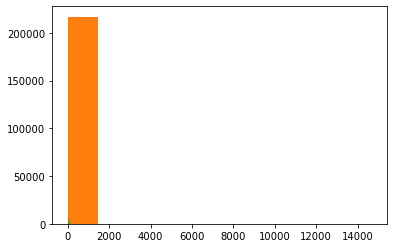

In [11]:
# look at review dist
plt.hist([math.log(x+1) for x in data_users.review_count])
print(plt.hist(data_users.review_count))
print(plt.hist(data_users.review_count[data_users.review_count<=100]))


(array([113997.,  37063.,  17023.,   9724.,   6416.,   4762.,   3441.,
         2704.,   2176.,   1873.]), array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]), <BarContainer object of 10 artists>)


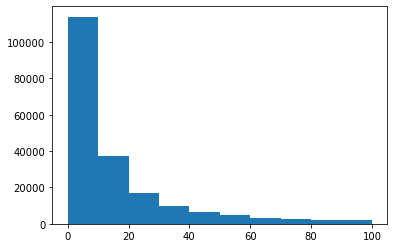

In [12]:
print(plt.hist(data_users.review_count[data_users.review_count<=100]))


In [5]:
# look at businesses
data_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Caribbean,Thai,Soul Food,Tapas Bars,Food Trucks,Drugstores,Tapas/Small Plates,Soup,Food Delivery Services,Automotive
0,z8-_6l5EhX5NuPfWzJYQMA,Great Wraps,3393 Peachtree Rd NE,Atlanta,GA,30326.0,33.846335,-84.363578,3.0,11,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Q2vefh0tGhtCGQDK1FI7cw,Piece of Cake,3215 Roswell Rd NE,Atlanta,GA,30305.0,33.842875,-84.378539,4.0,231,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TbZDLpBOl-EbO2LfMySrEg,First China Restaurant,5295 Buford Hwy NE,Atlanta,GA,30340.0,33.896640,-84.280918,3.0,11,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,bP6goJODwRnM3AVy45Kn9w,Papi's Cuban & Caribbean Grill,216 Ponce De Leon Ave NE,Atlanta,GA,30308.0,33.772758,-84.380375,4.0,1001,...,1.361251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,yCeENvVAGQQ0PeeWU0Pl2g,Nature's Table Bistro,"6000 N Terminal Pkwy, Concourse E Centrepoint,...",Atlanta,GA,30320.0,33.640879,-84.425514,3.5,150,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
data_business.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'category', 'WiFi',
       'RestaurantsGoodForGroups', 'HasTV', 'RestaurantsAttire', 'NoiseLevel',
       'OutdoorSeating', 'RestaurantsDelivery', 'RestaurantsReservations',
       'Caters', 'Alcohol', 'GoodForKids', 'BikeParking',
       'RestaurantsPriceRange2', 'RestaurantsTakeOut',
       'BusinessAcceptsCreditCards', 'Nightlife', 'Bars', 'American (New)',
       'Sandwiches', 'American (Traditional)', 'Coffee & Tea', 'Fast Food',
       'Breakfast & Brunch', 'Burgers', 'Event Planning & Services', 'Mexican',
       'Pizza', 'Desserts', 'Specialty Food', 'Seafood', 'Chicken Wings',
       'Salad', 'Italian', 'Bakeries', 'Southern', 'Cafes', 'Shopping',
       'Caterers', 'Beer', 'Wine & Spirits', 'Chinese', 'Cocktail Bars',
       'Asian Fusion', 'Ice Cream & Frozen Yogurt', 'Grocery', 'Sushi Bars',
       'Japanese', 'Barbeque', 'Juice Bars & Smoothies'

In [6]:
data_business.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'category', 'WiFi',
       'RestaurantsGoodForGroups', 'HasTV', 'RestaurantsAttire', 'NoiseLevel',
       'OutdoorSeating', 'RestaurantsDelivery', 'RestaurantsReservations',
       'Caters', 'Alcohol', 'GoodForKids', 'BikeParking',
       'RestaurantsPriceRange2', 'RestaurantsTakeOut',
       'BusinessAcceptsCreditCards', 'Nightlife', 'Bars', 'American (New)',
       'Sandwiches', 'American (Traditional)', 'Coffee & Tea', 'Fast Food',
       'Breakfast & Brunch', 'Burgers', 'Event Planning & Services', 'Mexican',
       'Pizza', 'Desserts', 'Specialty Food', 'Seafood', 'Chicken Wings',
       'Salad', 'Italian', 'Bakeries', 'Southern', 'Cafes', 'Shopping',
       'Caterers', 'Beer', 'Wine & Spirits', 'Chinese', 'Cocktail Bars',
       'Asian Fusion', 'Ice Cream & Frozen Yogurt', 'Grocery', 'Sushi Bars',
       'Japanese', 'Barbeque', 'Juice Bars & Smoothies'

In [7]:
data_business.shape

(5078, 84)

In [14]:
data_business.category.head(20)

0     Food, Restaurants, Cheesesteaks, Sandwiches, J...
1     Restaurants, Patisserie/Cake Shop, Desserts, F...
2                                  Restaurants, Chinese
3                         Caribbean, Cuban, Restaurants
4     Restaurants, Sandwiches, Fast Food, American (...
5                                 Restaurants, Southern
6     Restaurants, Nightlife, Mexican, Bars, Sports ...
7     Caterers, Event Planning & Services, Fast Food...
8                                 Restaurants, Southern
9     Latin American, Tapas Bars, Brazilian, Restaur...
10    American (New), Bars, Barbeque, Lounges, Night...
11                                 Restaurants, Chinese
12       Cheesesteaks, Burgers, Restaurants, Sandwiches
13                     Chinese, Restaurants, Vietnamese
14    Bars, American (Traditional), Nightlife, Barbe...
15    Caterers, Event Planning & Services, Beer, Win...
16    Vape Shops, Head Shops, Shopping, Food, Tobacc...
17    Nightlife, Pubs, Music Venues, Restaurants

In [15]:
data_business.describe()

,postal_code,latitude,longitude,stars,review_count,Nightlife,Bars,American (New),Sandwiches,American (Traditional),...,Caribbean,Thai,Soul Food,Tapas Bars,Food Trucks,Drugstores,Tapas/Small Plates,Soup,Food Delivery Services,Automotive
count,5074.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,...,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000
mean,30323.011431,33.796576,-84.381500,3.453427,121.820205,0.053511,0.052033,0.062476,0.059309,0.054736,...,0.019015,0.020357,0.016000,0.012050,0.012559,0.010398,0.009810,0.009703,0.010136,0.011219
std,50.292763,0.069653,0.048996,0.799132,231.844023,0.117847,0.117989,0.184808,0.177529,0.167789,...,0.162254,0.171153,0.135630,0.113282,0.114396,0.089858,0.090289,0.089417,0.099310,0.102287
min,30030.000000,33.601442,-84.549591,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30308.000000,33.756026,-84.403989,3.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30318.000000,33.786542,-84.380779,3.500000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,30329.000000,33.846222,-84.354288,4.000000,131.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,31136.000000,33.949424,-84.205442,5.000000,3861.000000,0.617088,0.631149,1.066832,1.111961,1.117794,...,2.041876,2.047560,2.065023,2.114923,2.114923,1.060769,2.148934,1.451977,2.193157,1.096579


In [16]:
data_business.astype(bool).sum(axis=0) # number of nonzeros

business_id               5078
name                      5078
address                   5078
city                      5078
state                     5078
                          ... 
Drugstores                  74
Tapas/Small Plates          70
Soup                        66
Food Delivery Services      64
Automotive                  64
Length: 84, dtype: int64

(array([  20.,  124.,  310.,  489.,    0.,  850., 1287., 1258.,  597.,
         143.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

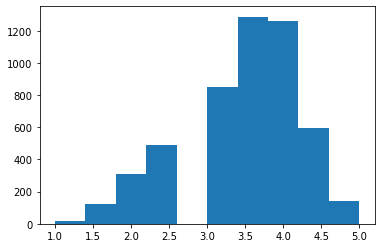

In [17]:
plt.hist(data_business.stars)

In [18]:
data_business.isnull().sum().sort_values(ascending=False)

NoiseLevel           2121
Caters               1886
RestaurantsAttire    1736
HasTV                1714
BikeParking          1700
                     ... 
Southern                0
Cafes                   0
Shopping                0
Caterers                0
Automotive              0
Length: 84, dtype: int64

In [19]:
# look at reviews
data_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year
0,Gi5LSRmTXoL9Bp4jNGPjLw,hn0ZbitvmlHnF--KJGJ6_A,TA1KUSCu8GkWP9w0rmElxw,4.0,0,0,0,I have been here twice and have had really goo...,2011-10-27 14:32:57,2011
1,Exip0vNybppf4e3nP9dwnA,lW4awVx0c1Er3ILxfHsYgQ,TA1KUSCu8GkWP9w0rmElxw,4.0,0,0,0,Eating healthy I had the turkey burger it was ...,2014-04-19 16:56:43,2014
2,WhDh4drkByXlQOrjVRH32g,Bt6gmjnWHPERhiOTQOhuEA,TA1KUSCu8GkWP9w0rmElxw,4.0,8,6,9,The only problem with Flip Burger Boutique is ...,2015-11-18 19:21:19,2015
3,vkI2hgdIaPWC84Ni-nxBGw,JxOPt7V1Oz_rdeoUoxm5rA,TA1KUSCu8GkWP9w0rmElxw,4.0,0,1,0,Me and The Piegon went this past Saturday arou...,2009-03-01 09:32:31,2009
4,He3WdC0igkkgDtkyXsdkaw,_2X3YAo_fDkzWOOpVVB1UA,TA1KUSCu8GkWP9w0rmElxw,3.0,1,2,1,ARE YOU SERIOUS? they got that beef tartare?!?...,2013-08-03 20:45:51,2013


In [20]:
#check sparsity
n_users = data_review.user_id.unique().shape[0]
n_items = data_review.business_id.unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of models: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(float(data_review.shape[0]) / float(n_users*n_items) * 100))

Number of users: 217169
Number of models: 5078
Sparsity: 0.058%


In [21]:
data_review.text[0]

"I have been here twice and have had really good food and service both times. I got a burger with caramelized onions, a red wine sauce and I believe blue cheese the first time. It was excellent and just the right size for me. I hate going out and ordering a burger that is bigger than my head that I can't even finish half of! Flip's burgers are about the same size I would make for myself at home.\n\nThe second time I went I had a limited time seasonal offering which was a venison burger with pea shoots, some kind of cheese that reminded me of brie, and a very sweet syrupy sauce which I could have done without, but overall it was very good. I also had onion rings and they were possibly the best onion rings I've had ever.\n\nThe only thing I don't really like about Flip is the atmosphere and layout of the tables. I guess they were going for trendy upscale or whatever, but it makes me feel as if I am in a school cafeteria back in high school. I don't like it. There are long white tables sh

In [22]:
data_review.describe()# need log cool,funny and useful

,stars,useful,funny,cool,year
count,637981.000000,637981.000000,637981.00000,637981.000000,637981.000000
mean,3.696102,0.943743,0.35355,0.457493,2015.645983
std,1.378694,2.655355,1.71699,2.054034,3.223623
min,1.000000,0.000000,0.00000,0.000000,2004.000000
25%,3.000000,0.000000,0.00000,0.000000,2014.000000
50%,4.000000,0.000000,0.00000,0.000000,2016.000000
75%,5.000000,1.000000,0.00000,0.000000,2018.000000
max,5.000000,411.000000,259.00000,371.000000,2021.000000


In [23]:
data_review.cool = pd.Series([math.log(x+1) for x in data_review.cool])
data_review.useful = pd.Series([math.log(x+1) for x in data_review.useful])
data_review.funny = pd.Series([math.log(x+1) for x in data_review.funny])

In [24]:
data_review.describe()

,stars,useful,funny,cool,year
count,637981.000000,637981.000000,637981.000000,637981.000000,637981.000000
mean,3.696102,0.416095,0.162992,0.212198,2015.645983
std,1.378694,0.600849,0.409941,0.454200,3.223623
min,1.000000,0.000000,0.000000,0.000000,2004.000000
25%,3.000000,0.000000,0.000000,0.000000,2014.000000
50%,4.000000,0.000000,0.000000,0.000000,2016.000000
75%,5.000000,0.693147,0.000000,0.000000,2018.000000
max,5.000000,6.021023,5.560682,5.918894,2021.000000


(array([4.98627e+05, 1.12761e+05, 1.56740e+04, 8.32100e+03, 1.98700e+03,
        4.12000e+02, 1.35000e+02, 2.70000e+01, 2.90000e+01, 8.00000e+00]),
 array([0.        , 0.59188939, 1.18377877, 1.77566816, 2.36755754,
        2.95944693, 3.55133631, 4.1432257 , 4.73511508, 5.32700447,
        5.91889385]),
 <BarContainer object of 10 artists>)

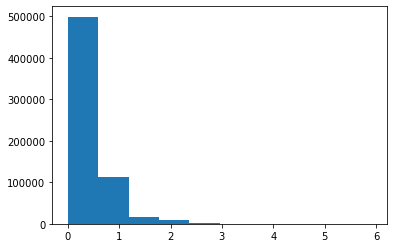

In [25]:
plt.hist(data_review.cool)# still very skewed

(array([5.31451e+05, 8.54760e+04, 1.25580e+04, 5.84900e+03, 1.84700e+03,
        6.04000e+02, 1.25000e+02, 3.10000e+01, 3.00000e+01, 1.00000e+01]),
 array([0.        , 0.55606816, 1.11213633, 1.66820449, 2.22427265,
        2.78034082, 3.33640898, 3.89247714, 4.4485453 , 5.00461347,
        5.56068163]),
 <BarContainer object of 10 artists>)

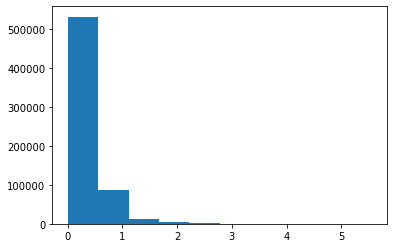

In [26]:
plt.hist(data_review.funny)

(array([3.87012e+05, 1.84416e+05, 4.81230e+04, 1.36250e+04, 3.77400e+03,
        7.87000e+02, 1.69000e+02, 3.90000e+01, 3.00000e+01, 6.00000e+00]),
 array([0.        , 0.60210233, 1.20420467, 1.806307  , 2.40840934,
        3.01051167, 3.61261401, 4.21471634, 4.81681868, 5.41892101,
        6.02102335]),
 <BarContainer object of 10 artists>)

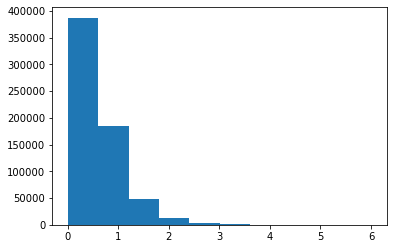

In [27]:
plt.hist(data_review.useful)

In [28]:
# look at dist of user ratings
data_review.stars.describe()

count    637981.000000
mean          3.696102
std           1.378694
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: stars, dtype: float64

(array([ 77612.,      0.,  60027.,      0.,      0.,  86983.,      0.,
        167367.,      0., 245992.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

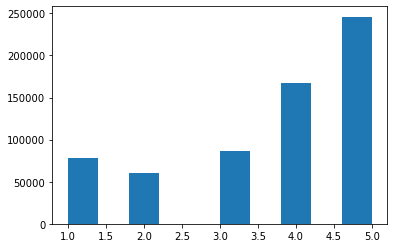

In [29]:
plt.hist(data_review.stars) # lots of 4 and 5s. 

In [30]:
#clean user skewness
data_users.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,...,Venues & Event Spaces,Soul Food,Drugstores,Grocery,Convenience Stores,Lounges,Sports Bars,Food Trucks,Barbeque,Asian Fusion
count,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,...,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000
mean,39.454181,81.662443,34.279847,48.773338,3.029134,3.663057,3.333293,0.556792,0.333082,0.250335,...,0.036916,0.041438,0.002850,0.006516,0.000663,0.016582,0.025119,0.004945,0.047857,0.016466
std,136.701157,979.729772,648.032750,853.039045,28.152563,1.020630,79.306959,11.030615,15.430432,9.016472,...,0.188556,0.199301,0.053312,0.080456,0.025742,0.127698,0.156486,0.070150,0.213464,0.127261
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000,0.000000,0.000000,3.130000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,5.000000,1.000000,1.000000,0.000000,3.830000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,26.000000,21.000000,4.000000,5.000000,1.000000,4.380000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,14691.000000,182600.000000,166330.000000,175463.000000,3237.000000,5.000000,20249.000000,4053.000000,6365.000000,2962.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
# clean user skewness
data_users.review_count = pd.Series([math.log(x+1) for x in data_users.review_count])
data_users.useful =  pd.Series([math.log(x+1) for x in data_users.useful])

#cleam business skewness
data_business.review_count =  pd.Series([math.log(x+1) for x in data_business.review_count])

In [32]:
data_users.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,...,Venues & Event Spaces,Soul Food,Drugstores,Grocery,Convenience Stores,Lounges,Sports Bars,Food Trucks,Barbeque,Asian Fusion
count,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,...,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000
mean,2.488676,2.017508,34.279847,48.773338,3.029134,3.663057,3.333293,0.556792,0.333082,0.250335,...,0.036916,0.041438,0.002850,0.006516,0.000663,0.016582,0.025119,0.004945,0.047857,0.016466
std,1.351941,1.764077,648.032750,853.039045,28.152563,1.020630,79.306959,11.030615,15.430432,9.016472,...,0.188556,0.199301,0.053312,0.080456,0.025742,0.127698,0.156486,0.070150,0.213464,0.127261
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.386294,0.693147,0.000000,0.000000,0.000000,3.130000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.302585,1.791759,1.000000,1.000000,0.000000,3.830000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.295837,3.091042,4.000000,5.000000,1.000000,4.380000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.595058,12.115059,166330.000000,175463.000000,3237.000000,5.000000,20249.000000,4053.000000,6365.000000,2962.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
#look to see if has duplicated reviews
a = data_review.groupby(['business_id','user_id']).agg(['count']).reset_index()

In [34]:
tmp = a.useful.sort_values(by = 'count',ascending = False).reset_index()
tmp[tmp['count'] >1].shape # 10179 user has multiple review for one business

(17162, 2)

In [35]:
multi_review_user_idx = tmp[tmp['count'] >1]
multi_review_user_idx = multi_review_user_idx['index']
multi_review_user_idx

0        578148
1        469396
2        401332
3        101333
4        434361
          ...  
17157    312968
17158     84693
17159    319662
17160    617997
17161    163904
Name: index, Length: 17162, dtype: int64

In [36]:
idxx = 19
tmp = data_review[(data_review.user_id == a.loc[multi_review_user_idx[idxx],'user_id'][0]) &
           (data_review.business_id == a.loc[multi_review_user_idx[idxx],'business_id'][0])]
tmp = tmp.sort_values(by = 'date',ascending = True)# Have duplicate comment values. Not sure what would happen
tmp

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year
547593,fkMiipV4j_DG5nSoBnZvbg,s4NgvdIfBH3UQdccWCyARg,Af2kgWjIoS_N-A5oTBlSVg,4.0,0.693147,0.000000,0.000000,It's really a shame when you live 300 feet awa...,2009-07-26 16:49:53,2009
547580,K9xiU6Ndcu2QswJOhozyJA,s4NgvdIfBH3UQdccWCyARg,Af2kgWjIoS_N-A5oTBlSVg,5.0,0.000000,0.000000,0.000000,I just love beef. Love it. And the CAB tenderl...,2009-07-29 16:41:48,2009
547552,GY4Wqibw-81va_t8Z69LPA,s4NgvdIfBH3UQdccWCyARg,Af2kgWjIoS_N-A5oTBlSVg,5.0,0.000000,0.000000,0.000000,"Oh, I hate being late.\n\nI came in at the tai...",2009-09-28 01:00:03,2009
547606,uWAZNVKgY9iWzxQzQ-Nqjg,s4NgvdIfBH3UQdccWCyARg,Af2kgWjIoS_N-A5oTBlSVg,5.0,1.791759,0.693147,0.693147,It's been on my list to get over to Haven on a...,2010-01-06 05:17:40,2010
547472,OqgLt7Y_Q3PyhAUAzEiJNA,s4NgvdIfBH3UQdccWCyARg,Af2kgWjIoS_N-A5oTBlSVg,5.0,0.693147,1.098612,1.098612,"OK, really?? Really?? HOW can I keep discoveri...",2010-02-01 02:07:54,2010
547446,QD0qLtS8zEDo_MVKnO3yFg,s4NgvdIfBH3UQdccWCyARg,Af2kgWjIoS_N-A5oTBlSVg,5.0,0.000000,1.098612,1.386294,So a quick update to brag on Haven a little mo...,2010-07-13 19:00:02,2010
547586,diJA_YdYt1dKYNy2sIE9Ow,s4NgvdIfBH3UQdccWCyARg,Af2kgWjIoS_N-A5oTBlSVg,5.0,0.693147,0.000000,1.386294,So it was a pretty perfect day off. Luke's bab...,2012-06-25 11:58:37,2012
547477,pGbPr1NFpNGRpae8_y7ZRA,s4NgvdIfBH3UQdccWCyARg,Af2kgWjIoS_N-A5oTBlSVg,5.0,0.693147,0.000000,0.693147,Another visit to one of my old favorite haunts...,2013-03-04 12:41:26,2013


In [37]:
tmp.text[547593] #162941

'It\'s really a shame when you live 300 feet away from not one, but two, great restaurants. A shame for your wallet and waistline, that is! I\'m lucky enough to live within spittin\' distance (as my country cousins would say) of Haven and Valenza.\n\nIt\'d been a couple of years since I\'d been to Haven, and I think subconsciously I\'d been putting off a return visit because I now live so close. I saw the problem in the making!\n\nI\'m a serial monogamist when it comes to food. Certain dishes, or specific foods . . . I\'ll eat them over and over until I exhaust my taste buds and have to move onto something else. Haven\'s homemade Spinach and Ricotta ravioli with sweet garlic and an heirloom tomato broth is my newest boyfriend. A plate of heaven, with lightly filled ravioli, just enough spinach and ricotta in the slightly flattened and rectangular pasta, and orange, yellow and red tomatoes of perfect ripeness. I rarely finish an entire dish and I had to literally stop myself from eating

In [38]:
data_users[data_users.user_id == a.loc[multi_review_user_idx[idxx],'user_id'][0]]

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,Venues & Event Spaces,Soul Food,Drugstores,Grocery,Convenience Stores,Lounges,Sports Bars,Food Trucks,Barbeque,Asian Fusion
1143,s4NgvdIfBH3UQdccWCyARg,Carrie Neal,7.103322,2008-04-09 02:58:24,8.448486,2199,3432,"2008,2009,2010,2011,2012,2014,2015,2016,2017,2...","b9Azt2DNyTP9QJZdRFs8jw, zZ6NbyzPmqOd7qW-FRG9FQ...",186,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# take user latest rating as sole rating

for idxx in range(len(multi_review_user_idx)):
    tmp = data_review[(data_review.user_id == a.loc[multi_review_user_idx[idxx],'user_id'][0]) &
           (data_review.business_id == a.loc[multi_review_user_idx[idxx],'business_id'][0])].sort_values(
        by = 'date',ascending = True)
    
    data_review.drop(tmp.index[0:len(tmp.index)-1],inplace=True)
    

KeyboardInterrupt: 

In [ ]:
# check if all deleted
#look to see if has duplicated reviews
b = data_review.groupby(['business_id','user_id']).agg(['count']).reset_index()
tmp = b.useful.sort_values(by = 'count',ascending = False).reset_index()
tmp[tmp['count'] >1].shape # all deleted

In [ ]:
data_review.stars[data_review.user_id == user]

In [32]:
data_users = pd.read_csv('/Users/vikaschaturvedi/Documents/T-Systems/POC/Recommender/Yelp-Recommender-master/data/interim/users_atlanta.csv')
print(data_users.shape)
data_users.head()

(217169, 24)


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,is_elite,year
0,q_QQ5kBBwlCcbL1s4NVK3g,Jane,1220,2005-03-14 20:26:35,15038,10030,11291,"2006,2007,2008,2009,2010,2011,2012,2013,2014","xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",1357,...,361,147,1212,5691,2541,2541,815,323,True,2005
1,dIIKEfOgo0KqUfGQvGikPg,Gabi,2136,2007-08-10 19:01:51,21272,10289,18046,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2...","XPzYf9_mwG2eXYP2BAGSTA, 2LooM5dcIk2o01nftYdPIg...",1025,...,232,96,1187,3293,2205,2205,472,294,True,2007
2,eCJoZqpV1fDKJGAsXmWXqQ,Bridget,51,2009-07-22 16:47:01,53,14,16,NaN,"DlT1HhrcYfDhjJNUyskU5g, C0ly5C7RzTlzh0M55YspDw...",1,...,0,0,3,1,2,2,1,0,False,2009
3,1jXmzuIFKxTnEnR0pxO0Hg,Clara,299,2010-10-01 17:29:36,381,106,121,"2010,2011,2012,2013,2014,2015","VGfzq5na6LZUwxwWO5eVLA, 35uHDsVOEsWbLdEg8Ttobg...",23,...,6,0,17,47,30,30,4,1,True,2010
4,MUzkXfPS9JaMgJ907orz0g,Damon,750,2009-01-29 03:48:53,2235,801,893,"2010,2012,2013,2014,2015,2016,2017,2018,2019,2...","dyfc7mHf52_EKUBPHJ1NJw, 4gAD7fnWZNYP3TIMJGyt5A...",86,...,3,4,72,165,162,162,54,17,True,2009


In [35]:
data_users.average_stars.unique()

array([3.85, 4.09, 3.86, 3.43, 4.16, 3.66, 3.65, 3.61, 3.57, 3.44, 3.68,
       3.64, 3.36, 3.51, 3.9 , 3.22, 3.31, 4.03, 4.07, 3.92, 4.02, 3.84,
       3.94, 4.24, 3.74, 3.89, 3.62, 3.45, 4.13, 3.52, 3.58, 4.18, 4.19,
       3.78, 3.91, 3.96, 3.5 , 4.  , 3.4 , 3.82, 4.11, 3.72, 3.7 , 3.37,
       4.05, 3.42, 3.97, 3.35, 3.88, 2.45, 3.87, 3.93, 3.95, 3.24, 4.14,
       4.47, 4.04, 3.99, 4.32, 3.56, 3.15, 4.69, 3.81, 3.8 , 2.99, 4.36,
       3.69, 4.53, 3.67, 3.2 , 4.76, 3.55, 3.75, 4.1 , 4.4 , 3.83, 3.6 ,
       3.76, 3.49, 3.77, 2.57, 3.63, 4.23, 4.3 , 4.29, 2.88, 4.17, 4.49,
       3.41, 3.79, 3.71, 4.27, 3.29, 4.59, 3.33, 3.54, 4.33, 3.53, 3.3 ,
       4.12, 3.25, 3.27, 3.73, 2.83, 3.13, 3.48, 3.38, 4.15, 3.19, 3.11,
       3.23, 4.06, 2.89, 3.18, 3.59, 3.34, 4.08, 3.46, 3.14, 4.37, 3.28,
       3.26, 4.25, 1.5 , 4.38, 3.17, 2.27, 4.46, 3.12, 4.83, 2.  , 3.09,
       4.44, 4.22, 3.07, 4.26, 3.32, 1.95, 3.98, 4.7 , 4.75, 4.28, 4.51,
       3.02, 3.47, 3.  , 4.01, 4.2 , 3.21, 3.39, 4.

In [33]:
data_users.average_stars[data_users.user_id == 'dIIKEfOgo0KqUfGQvGikPg']

1    4.09
Name: average_stars, dtype: float64

In [65]:
# # subtract user avg rating to count for bias and make neg to -1 and pos to 1

# unique_users = data_review.user_id.unique()

# for i,user in enumerate(unique_users):
#     print(i)
#     if(i == 0):
#         continue
#     # get avg rating
#     this_avg = float(data_users.average_stars[data_users.user_id == user])
#     # get user review mtrx
#     tmp = data_review.stars[data_review.user_id == user] - this_avg
#     tmp[tmp>0] = 1
#     tmp[tmp<0] = -1
#     data_review.stars[data_review.user_id == user] = tmp


In [ ]:
# What we need to do
# Scale the rating between -1 to 1  by subtracting user's actual rating in Review dataset

In [43]:
data_review_1 = data_review.merge(data_users[['user_id','average_stars']],on=['user_id'],how='left')
print(data_review_1.shape)
data_review_1.head()

(637981, 11)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year,average_stars
0,Gi5LSRmTXoL9Bp4jNGPjLw,hn0ZbitvmlHnF--KJGJ6_A,TA1KUSCu8GkWP9w0rmElxw,4.0,0,0,0,I have been here twice and have had really goo...,2011-10-27 14:32:57,2011,3.26
1,Exip0vNybppf4e3nP9dwnA,lW4awVx0c1Er3ILxfHsYgQ,TA1KUSCu8GkWP9w0rmElxw,4.0,0,0,0,Eating healthy I had the turkey burger it was ...,2014-04-19 16:56:43,2014,3.87
2,WhDh4drkByXlQOrjVRH32g,Bt6gmjnWHPERhiOTQOhuEA,TA1KUSCu8GkWP9w0rmElxw,4.0,8,6,9,The only problem with Flip Burger Boutique is ...,2015-11-18 19:21:19,2015,3.98
3,vkI2hgdIaPWC84Ni-nxBGw,JxOPt7V1Oz_rdeoUoxm5rA,TA1KUSCu8GkWP9w0rmElxw,4.0,0,1,0,Me and The Piegon went this past Saturday arou...,2009-03-01 09:32:31,2009,4.09
4,He3WdC0igkkgDtkyXsdkaw,_2X3YAo_fDkzWOOpVVB1UA,TA1KUSCu8GkWP9w0rmElxw,3.0,1,2,1,ARE YOU SERIOUS? they got that beef tartare?!?...,2013-08-03 20:45:51,2013,2.76


In [50]:
data_review_1['stars_x'] = data_review_1['stars']-data_review_1['average_stars']

In [53]:
data_review_1['stars_x1'] = np.where(data_review_1['stars_x']>0,1,-1)

In [56]:
data_review_1['stars_x1'] = np.where(data_review_1['stars_x']==0,0,data_review_1['stars_x1'])

In [57]:
data_review_1.stars_x1.unique()

array([ 1, -1,  0])

In [64]:
data_review_1.loc[data_review_1['stars_x']<0].head(10)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year,average_stars,stars_x,stars_x1
3,vkI2hgdIaPWC84Ni-nxBGw,JxOPt7V1Oz_rdeoUoxm5rA,TA1KUSCu8GkWP9w0rmElxw,4.0,0,1,0,Me and The Piegon went this past Saturday arou...,2009-03-01 09:32:31,2009,4.09,-0.09,-1
6,hHKE4JG8lF8qbcrwAx1xfw,NWt_557ZHA2KN6-7Umr2OQ,TA1KUSCu8GkWP9w0rmElxw,3.0,0,0,0,93 Health Score - Thumbs Up!\n\nThe Hostess an...,2018-06-08 22:21:44,2018,3.48,-0.48,-1
7,V5w8UYFCyqp1OdpFuHyIOw,UV9yHJBOAQEnPtNXZuIOMg,TA1KUSCu8GkWP9w0rmElxw,3.0,2,1,0,Went to a pre-opening here. Loved the concept...,2008-12-04 03:21:48,2008,3.28,-0.28,-1
16,LfpTxjAjSUrslq4pw5nt0A,0nNkPs8drd8dSA_RSx2hyA,TA1KUSCu8GkWP9w0rmElxw,3.0,0,0,0,After all the hype I've heard about this place...,2012-06-26 13:50:32,2012,3.91,-0.91,-1
18,th0rgx_PisyQyuCIVylGjQ,fI36ihAfQcwwdAdJJOKSHg,TA1KUSCu8GkWP9w0rmElxw,3.0,0,0,0,FLIP Burger Boutique has a very simple premise...,2009-10-13 14:09:16,2009,3.54,-0.54,-1
20,LdxufLcAcHFpxfOvK_3k7A,kB6NqgoU2wpLqYoF21k_uA,TA1KUSCu8GkWP9w0rmElxw,3.0,3,1,1,Unique combinations paired with fairly edgy id...,2008-12-04 02:07:15,2008,3.66,-0.66,-1
22,eN8_t6CNokVGMf8l0ChI_g,BGGEU2Bvj1bdcN8AGofazQ,TA1KUSCu8GkWP9w0rmElxw,3.0,0,0,1,It had been a very long overdue trip to flip B...,2011-06-29 21:12:06,2011,3.94,-0.94,-1
23,g6Q84u4d5EB8rvqj5Fmmjw,bAiFQACvrvt5ta_dbjSuGw,TA1KUSCu8GkWP9w0rmElxw,1.0,0,0,0,Visited Flip Burger on Thursday evening for di...,2018-08-24 01:30:37,2018,4.00,-3.00,-1
26,rDBwE3tZIjZJ7mUg4zhNzA,F9f5_srXoQqY8lb6px8rRg,TA1KUSCu8GkWP9w0rmElxw,2.0,0,0,0,The burgers were disappointing! I personally d...,2018-04-15 14:38:20,2018,3.67,-1.67,-1
29,6-vjhl5SHOPg1jf5sKDOqQ,w6V7H8jNfOBYpEg7b1gBWg,TA1KUSCu8GkWP9w0rmElxw,1.0,1,0,0,"Sorry, but this is not a comment on the food. ...",2012-04-29 12:39:52,2012,3.00,-2.00,-1


In [59]:
data_review_1.isnull().sum()

review_id        0
user_id          0
business_id      0
stars            0
useful           0
funny            0
cool             0
text             0
date             0
year             0
average_stars    0
stars_x          0
stars_x1         0
dtype: int64

In [60]:
# save this version of data_review
data_review_1.to_csv('/Users/vikaschaturvedi/Documents/T-Systems/POC/Recommender/Yelp-Recommender-master/data/interim/reviews_cleaned.csv',index=False)

In [47]:
# read in cleaned review data
data_review = pd.read_csv('/Users/vikaschaturvedi/Documents/T-Systems/POC/Recommender/Yelp-Recommender-master/data/interim/reviews_cleaned.csv')

In [14]:
# tmp = pd.pivot_table(data_review, values='stars', index=['user_id'],
#                     columns=['business_id'], aggfunc=np.sum,fill_value = 0)


In [18]:
#tmp.to_csv('/Users/ivanchen/Desktop/MSIA/Courses/Blog/git/interactions.csv')

In [48]:
data_review.drop(['stars_x','stars'],axis=1,inplace=True)
data_review.rename(columns={'stars_x1':'stars'},inplace=True)

In [49]:
# check user interactions distribution
tmp = data_review.groupby('user_id').count().reset_index()
tmp.describe() # many users do not have much interactions, a serious cold start problem as expected.

,review_id,business_id,useful,funny,cool,text,date,year,average_stars,stars
count,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000,217169.000000
mean,2.937717,2.937717,2.937717,2.937717,2.937717,2.937717,2.937717,2.937717,2.937717,2.937717
std,9.234465,9.234465,9.234465,9.234465,9.234465,9.234465,9.234465,9.234465,9.234465,9.234465
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000


(array([1.69762e+05, 2.32210e+04, 1.30040e+04, 6.32700e+03, 2.95000e+03,
        1.29700e+03, 4.52000e+02, 1.35000e+02, 1.80000e+01, 3.00000e+00]),
 array([0.        , 0.70370276, 1.40740552, 2.11110828, 2.81481105,
        3.51851381, 4.22221657, 4.92591933, 5.62962209, 6.33332485,
        7.03702761]),
 <BarContainer object of 10 artists>)

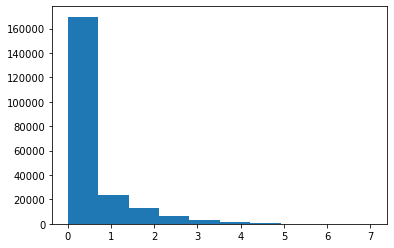

In [50]:
plt.hist(pd.Series([math.log(x) for x in tmp.useful])) # highly right skewed

In [51]:
data_review.columns

Index(['review_id', 'user_id', 'business_id', 'useful', 'funny', 'cool',
       'text', 'date', 'year', 'average_stars', 'stars'],
      dtype='object')

In [52]:
#model establishment
dataset = Dataset()
dataset.fit(data_review.user_id,data_review.business_id)
type(dataset)
num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))


Num users: 217169, num_items 5078.


In [58]:
data_users.isnull().sum().sort_values(ascending=False)

elite            197804
name                  1
Vegan                 0
Sushi Bars            0
Delis                 0
                  ...  
Cocktail Bars         0
Chinese               0
Caterers              0
Cafes                 0
Asian Fusion          0
Length: 61, dtype: int64

In [55]:
data_users.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos', 'is_elite', 'year', 'Ice Cream & Frozen Yogurt',
       'Cocktail Bars', 'Chinese', 'Caterers', 'Cafes', 'Caribbean', 'Thai',
       'Tex-Mex', 'Shopping', 'Sushi Bars', 'Delis', 'Japanese', 'Vegetarian',
       'Wine Bars', 'Juice Bars & Smoothies', 'Tapas Bars',
       'Arts & Entertainment', 'Beer', 'Mediterranean', 'Automotive', 'Diners',
       'Pubs', 'Vegan', 'Soup', 'Tapas/Small Plates', 'Steakhouses',
       'Food Delivery Services', 'Venues & Event Spaces', 'Soul Food',
       'Drugstores', 'Grocery', 'Convenience Stores', 'Lounges', 'Sports Bars',
       'Food Trucks', 'Barbeque', 'Asian Fusion'],
 

In [88]:
# fit item and user features. 


dataset.fit_partial(items=data_business.business_id,
                    item_features=['stars'])
# dataset.fit_partial(items=data_business.business_id,
#                     item_features=data_business.longitude)
# dataset.fit_partial(items=data_business.business_id,
#                     item_features=data_business.latitude)
dataset.fit_partial(items=data_business.business_id,
                    item_features=['review_count'])
# fit tags
# start_idx = 24
# for i in range(start_idx,len(data_business.columns)):
#     dataset.fit_partial(items=data_business.business_id,
#                     item_features=data_business[data_business.columns[i]])
tar_cols = [x for x in data_business.columns[26:]]

dataset.fit_partial(items = data_business.business_id,
                   item_features = tar_cols)                                    
                                                
# # dataset.fit_partial(users=data_users.user_id,
# #                     user_features=data_users.review_count)
# dataset.fit_partial(users=data_users.user_id,
#                     user_features=data_users.is_elite)
# # dataset.fit_partial(users=data_users.user_id,
# #                     user_features=data_users.useful)
# dataset.fit_partial(users=data_users.user_id,
#                     user_features=data_users.year)


user_cols = [x for x in data_users[['review_count', 'useful', 'is_elite',
                                   'Ice Cream & Frozen Yogurt',
       'Cocktail Bars', 'Chinese', 'Caterers', 'Cafes', 'Caribbean', 'Thai',
       'Tex-Mex', 'Shopping', 'Sushi Bars', 'Delis', 'Japanese', 'Vegetarian',
       'Wine Bars', 'Juice Bars & Smoothies', 'Tapas Bars',
       'Arts & Entertainment', 'Beer', 'Mediterranean', 'Automotive', 'Diners',
       'Pubs', 'Vegan', 'Soup', 'Tapas/Small Plates', 'Steakhouses',
       'Food Delivery Services', 'Venues & Event Spaces', 'Soul Food',
       'Drugstores', 'Grocery', 'Convenience Stores', 'Lounges', 'Sports Bars',
       'Food Trucks', 'Barbeque', 'Asian Fusion']]]
dataset.fit_partial(users=data_users.user_id,
                    user_features = user_cols)

# Check data
print(type(dataset))
print(dataset.model_dimensions())
print(dataset.user_features_shape())
print(dataset.item_features_shape())
#print(dataset.mapping())
print(dataset.interactions_shape())



<class 'lightfm.data.Dataset'>
(217209, 5140)
(217169, 217209)
(5078, 5140)
(217169, 5078)


In [89]:
# look at item feature mapping
a = dataset.mapping()[3]
list(a.items())[0:10]


[('TA1KUSCu8GkWP9w0rmElxw', 0),
 ('gGvNgShksetPoimyKV8I9Q', 1),
 ('ZW7aI5FO_3q_vSzI4_zx-Q', 2),
 ('dWBKYjQ3q2v2dOjsfLLxDg', 3),
 ('IdXHHEUH4ebcxdRxCo3JNw', 4),
 ('p2BkIrOuIsxGqtV0lwOZUw', 5),
 ('AvXqLbcGCxdIEF_qZTY0Kw', 6),
 ('SNn6O_vN8EtR-UFYtzYZ-Q', 7),
 ('Y6xGZZIQEtwjCkVHL-_GRg', 8),
 ('ll5v-nUVgMsTMUC-MBGRFQ', 9)]

In [90]:
#build interaction
(interactions, weights) = dataset.build_interactions([(x['user_id'],
                                                       x['business_id'],
                                                       x['stars']) for index,x in data_review.iterrows()])

print(repr(interactions))

#item features
# item_info_copy=data_business.iloc[[i for i in range(data_business.shape[0]) 
#                                    if data_business.business_id[i] in data_review.business_id.unique()],:]
# print(item_info_copy.shape)
#item_features = dataset.build_item_features(((x['item'], [x['category']])
 #                                             for index,x in data_meta.iterrows()))
    

"""
Build a item features matrix out of an iterable of the form (item id, [list of feature names]) or (item id, {feature name: feature weight}).

Parameters:	
data (iterable of the form) – (item id, [list of feature names]) or (item id, {feature name: feature weight}). Item and feature ids will be translated to internal indices constructed during the fit call.
normalize (bool, optional) – If true, will ensure that feature weights sum to 1 in every row.
Returns:	
feature matrix – Matrix of item features.

Return type:	
CSR matrix (num items, num features)
"""    

<217169x5078 sparse matrix of type '<class 'numpy.int32'>'
	with 637981 stored elements in COOrdinate format>


'\nBuild a item features matrix out of an iterable of the form (item id, [list of feature names]) or (item id, {feature name: feature weight}).\n\nParameters:\t\ndata (iterable of the form) – (item id, [list of feature names]) or (item id, {feature name: feature weight}). Item and feature ids will be translated to internal indices constructed during the fit call.\nnormalize (bool, optional) – If true, will ensure that feature weights sum to 1 in every row.\nReturns:\t\nfeature matrix – Matrix of item features.\n\nReturn type:\t\nCSR matrix (num items, num features)\n'

In [132]:
joblib.dump(interactions, "/Users/vikaschaturvedi/Documents/T-Systems/POC/Recommender/Yelp-Recommender-master/interactions.pkl")
joblib.dump(weights, "/Users/vikaschaturvedi/Documents/T-Systems/POC/Recommender/Yelp-Recommender-master/weights.pkl")

['/Users/vikaschaturvedi/Documents/T-Systems/POC/Recommender/Yelp-Recommender-master/weights.pkl']

# build user and item features

In [91]:
def build_dict(df,tar_cols,val_list):
    rst = {}
    for col in tar_cols:
        rst[col] = df[col]
    sum_val = sum(list(rst.values())) # get sum of all the tfidf values
    
    if(sum_val == 0):
        return rst
    else:
        
        w = (2-sum(val_list))/sum_val # weight for each tag to be able to sum to 1
        for key,value in rst.items():
            rst[key] = value * w
    return rst

def user_build_dict(df,tar_cols,val_list):
    rst = {}
    for col in tar_cols:
        rst[col] = df[col]
    sum_val = sum(list(rst.values())) # get sum of all the tfidf values
    
    if(sum_val == 0):
        return rst
    else:
        w = (2-sum(val_list))/sum_val # weight for each tag to be able to sum to 1
        for key,value in rst.items():
            rst[key] = value * w
    return rst

In [92]:
# get max of each column to regularize value to [0,1]
max_star = max(data_business.stars)
print('max_star: ',max_star)
max_b_rc = max(data_business.review_count)
print('max_b_rc: ',max_b_rc)

max_star:  5.0
max_b_rc:  8.258940462988459


In [93]:
# give CF info weight 0.5, all other 0.5. Then in others, give (star, review count) 0.25 and tags 0.25
item_features = dataset.build_item_features(((x['business_id'], 
                                              {'stars':0.5*x['stars']/max_star,
                                               'review_count':0.5*x['review_count']/max_b_rc,
                                               **build_dict(x,tar_cols,[0.5*x['stars']/max_star,
                                                           0.5*x['review_count']/max_b_rc])})
                                              for index,x in data_business.iterrows()))

print(repr(item_features))
print(item_features.shape)

# user_features = dataset.build_user_features(((x['user_id'],
#                                              [x['is_elite'],x['year']])
#                                            for index, x in data_users.iterrows()))


<5078x5140 sparse matrix of type '<class 'numpy.float32'>'
	with 309758 stored elements in Compressed Sparse Row format>
(5078, 5140)


In [130]:
joblib.dump(item_features, "/Users/vikaschaturvedi/Documents/T-Systems/POC/Recommender/Yelp-Recommender-master/item_features.pkl")

['/Users/vikaschaturvedi/Documents/T-Systems/POC/Recommender/Yelp-Recommender-master/item_features.pkl']

In [94]:
max_u_rc = max(data_users.review_count)
max_useful = max(data_users.useful)
user_features = dataset.build_user_features(((x['user_id'],
                                             {'review_count':0.35*x['review_count']/max_u_rc,'is_elite':0.35*int(x['is_elite']),
                                              'useful':0.35*x['useful']/max_useful,
                                             **user_build_dict(x,user_cols,[0.35*x['review_count']/max_u_rc,
                                                                            0.35*int(x['is_elite']),
                                                                            0.35*x['useful']/max_useful])})
                                           for index, x in data_users.iterrows()))



print(repr(user_features))
print(user_features.shape)

<217169x217209 sparse matrix of type '<class 'numpy.float32'>'
	with 8903929 stored elements in Compressed Sparse Row format>
(217169, 217209)


In [131]:
joblib.dump(user_features, "/Users/vikaschaturvedi/Documents/T-Systems/POC/Recommender/Yelp-Recommender-master/user_features.pkl")

['/Users/vikaschaturvedi/Documents/T-Systems/POC/Recommender/Yelp-Recommender-master/user_features.pkl']

In [95]:
# check features to see if weights make sense
idx = 3
tt = list(item_features[idx].nonzero())
print(item_features[idx].shape)
print(tt)

uu = list(user_features[idx].nonzero())
print(user_features[idx].shape)
uu

(1, 5140)
[array([0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32), array([   3, 5078, 5079, 5082, 5083, 5089, 5101, 5117, 5132], dtype=int32)]
(1, 217209)


[array([0, 0, 0, 0, 0], dtype=int32),
 array([     3, 217169, 217170, 217171, 217189], dtype=int32)]

In [96]:
tt = item_features[idx].todense()
import pandas as pd
tt = pd.DataFrame(tt)
print(list(map(set,tt.values)))# feature weight sum to 1, so if two are nonzero, each take weight 0.5. 

uu = user_features[idx].todense()
uu = pd.DataFrame(uu)
list(map(set,uu.values))# feature weight sum to 1, so if two are nonzero, each take weight 0.5. 



[{0.0, 0.33333334, 0.04435056, 0.11666667, 0.14074604, 0.045361117, 0.060889784, 0.07384563, 0.08586378, 0.09894309}]


[{0.0, 0.059210077, 0.22669414, 0.2372745, 0.4176112}]

In [97]:
tt

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

In [98]:
uu

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

In [107]:
interactions.todense()

matrix([[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]], dtype=int32)

In [99]:
#train-test split

# seed = 12345 #has multiple seeds set up to account for split biases
# seed = 101
# seed = 186
seed = 123
from lightfm.cross_validation import random_train_test_split
train,test=random_train_test_split(interactions,test_percentage=0.2,random_state=np.random.RandomState(seed))

print('The dataset has %s users and %s items, '
      'with %s interactions in the test and %s interactions in the training set.'
      % (train.shape[0], train.shape[1], test.getnnz(), train.getnnz()))

train.multiply(test).nnz == 0 # make sure train and test are truly disjoint

The dataset has 217169 users and 5078 items, with 127597 interactions in the test and 510384 interactions in the training set.


False

In [103]:
#model construction

from lightfm import LightFM

# Set the number of threads; you can increase this if you have more physical cores available.

## These parameters are obtained after tunning for specific loss through skopt in the bottom chunk
NUM_THREADS = 25
NUM_COMPONENTS = 43    
NUM_EPOCHS = 18
ITEM_ALPHA = 2.88752e-6
learning_rate=0.06652
k = 5 # for precision at k

## Pure Collaborative Filtering models

# Logistic loss
model = LightFM(loss='logistic',random_state=seed,
                item_alpha=ITEM_ALPHA,
               no_components=NUM_COMPONENTS,
               learning_rate=learning_rate)

# time it.
%time model = model.fit(train,epochs=NUM_EPOCHS,num_threads=NUM_THREADS)


# Import the evaluation routines
from lightfm.evaluation import auc_score

# Compute and print the AUC score
train_auc = auc_score(model, train, num_threads=NUM_THREADS).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

# We pass in the train interactions to exclude them from predictions.
# This is to simulate a recommender system where we do not
# re-recommend things the user has already interacted with in the train
# set.


test_auc = auc_score(model, test,num_threads=NUM_THREADS).mean()
print('Collaborative filtering test AUC: %s' % test_auc)



CPU times: user 13.7 s, sys: 80.8 ms, total: 13.7 s
Wall time: 13.8 s
Collaborative filtering train AUC: 0.84645534
Collaborative filtering test AUC: 0.84142876


In [113]:
# from lightfm.evaluation import precision_at_k,recall_at_k
# print("Train precision: %.4f" % precision_at_k(model, train, k=k,num_threads=NUM_THREADS).mean())
# print("Test precision: %.4f" % precision_at_k(model, test,train_interactions=train, k=k,num_threads=NUM_THREADS).mean())



In [595]:
#test corresponding recpmmendation
#transfer data_movies to have corresponding movieid with ratings
# rf.sample_train_recommendation(model,train,data_business,range(10),5,'name',mapping=dataset.mapping()[2],tag='category')

# user_index=list(set(rf.get_user_index(test)))
# rf.sample_test_recommendation(model,train,test,data_business,user_index[0:10],5,'name',mapping=dataset.mapping()[2],train_interactions=train,tag='category')


In [108]:
NUM_THREADS = 25
NUM_COMPONENTS = 45    
NUM_EPOCHS = 43
ITEM_ALPHA = 1.3846e-6
learning_rate=0.0161445

# BPR loss
model = LightFM(loss='bpr',random_state=seed,
                item_alpha=ITEM_ALPHA,
               no_components=NUM_COMPONENTS,
               learning_rate=learning_rate)

# time it.
%time model = model.fit(train,epochs=NUM_EPOCHS,num_threads=NUM_THREADS)


# Compute and print the AUC score
train_auc = auc_score(model, train, num_threads=NUM_THREADS).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

test_auc = auc_score(model, test,num_threads=NUM_THREADS).mean()
print('Collaborative filtering test AUC: %s' % test_auc)


CPU times: user 53.3 s, sys: 264 ms, total: 53.6 s
Wall time: 54 s
Collaborative filtering train AUC: 0.9549489
Collaborative filtering test AUC: 0.5908206


In [ ]:
print("Train precision: %.4f" % precision_at_k(model, train, k=k,num_threads=NUM_THREADS).mean())
print("Test precision: %.4f" % precision_at_k(model, test,train_interactions=train, k=k,num_threads=NUM_THREADS).mean())

In [109]:
NUM_THREADS = 25
NUM_COMPONENTS = 21    
NUM_EPOCHS = 16
ITEM_ALPHA = 5.97967e-6
learning_rate=0.033

# Let's fit a WARP model
model = LightFM(loss='warp',random_state=seed,
                item_alpha=ITEM_ALPHA,
               no_components=NUM_COMPONENTS,
               learning_rate=learning_rate)

#  time it.
%time model = model.fit(train,epochs=NUM_EPOCHS,num_threads=NUM_THREADS)



# Compute and print the AUC score
train_auc = auc_score(model, train, num_threads=NUM_THREADS).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

test_auc = auc_score(model, test,num_threads=NUM_THREADS).mean()
print('Collaborative filtering test AUC: %s' % test_auc)

CPU times: user 11.6 s, sys: 27 ms, total: 11.6 s
Wall time: 11.6 s
Collaborative filtering train AUC: 0.97958726
Collaborative filtering test AUC: 0.85024613


In [ ]:
print("Train precision: %.4f" % precision_at_k(model, train, k=k,num_threads=NUM_THREADS).mean())
print("Test precision: %.4f" % precision_at_k(model, test,train_interactions=train, k=k,num_threads=NUM_THREADS).mean())

# UF, IF & LOGISTIC

In [110]:
NUM_THREADS = 25
NUM_COMPONENTS = 30
learning_rate = 0.0053
NUM_EPOCHS = 6
ITEM_ALPHA = 2.228e-5

## Hybrid models

#Combine user_feature and item feature

#logistic loss
model.iii = LightFM(loss='logistic',
                item_alpha=ITEM_ALPHA,
                    random_state=seed,
               no_components=NUM_COMPONENTS)

# time it.
%time model.iii = model.iii.fit(train,user_features=user_features,item_features=item_features,epochs=NUM_EPOCHS,num_threads=NUM_THREADS)

# Compute and print the AUC score
train_auc = auc_score(model.iii, train,user_features=user_features,item_features=item_features, num_threads=NUM_THREADS).mean()
print(' Hybrid train AUC: %s' % train_auc)

test_auc = auc_score(model.iii, test,user_features=user_features,item_features=item_features,num_threads=NUM_THREADS).mean()
print('Hybrid test AUC: %s' % test_auc)



CPU times: user 54.6 s, sys: 56.4 ms, total: 54.6 s
Wall time: 54.8 s
 Hybrid train AUC: 0.7625691
Hybrid test AUC: 0.7642635


In [ ]:
#precision @k
print("Train precision: %.4f" % precision_at_k(model.iii, train,
                                               item_features=item_features,user_features=user_features, k=k,
                                               num_threads=NUM_THREADS).mean())
print("Test precision: %.4f" % precision_at_k(model.iii, test,train_interactions=train,
                                              item_features=item_features,user_features=user_features, k=k,
                                             num_threads=NUM_THREADS).mean())

# UF, IF & BPR

In [111]:

NUM_THREADS = 25
NUM_COMPONENTS = 77    
NUM_EPOCHS = 80
ITEM_ALPHA = 1.419e-6
learning_rate=0.035


# BPR
model.iii = LightFM(loss='bpr',
                item_alpha=ITEM_ALPHA,
                     random_state=seed,
               no_components=NUM_COMPONENTS)

#  time it.
%time model.iii = model.iii.fit(train,user_features=user_features,item_features=item_features,epochs=NUM_EPOCHS,num_threads=NUM_THREADS)


# Compute and print the AUC score
train_auc = auc_score(model.iii, train,user_features=user_features,item_features=item_features, num_threads=NUM_THREADS).mean()
print('Hybrid train AUC: %s' % train_auc)

test_auc = auc_score(model.iii, test,user_features=user_features,item_features=item_features,num_threads=NUM_THREADS).mean()
print('Hybrid test AUC: %s' % test_auc)




CPU times: user 44min 42s, sys: 1.41 s, total: 44min 43s
Wall time: 44min 45s
Hybrid train AUC: 0.96980983
Hybrid test AUC: 0.8359397


In [115]:
!pip install joblib

In [117]:
import joblib
joblib.dump(model, "/Users/vikaschaturvedi/Documents/T-Systems/POC/Recommender/Yelp-Recommender-master/model_bpr.pkl")

['/Users/vikaschaturvedi/Documents/T-Systems/POC/Recommender/Yelp-Recommender-master/model_bpr.pkl']

In [ ]:
#precision @k
print("Train precision: %.4f" % precision_at_k(model.iii, train,
                                               item_features=item_features,user_features=user_features, k=k,
                                              num_threads=NUM_THREADS).mean())#0.41
print("Test precision: %.4f" % precision_at_k(model.iii, test,train_interactions=train,
                                              item_features=item_features,user_features=user_features, k=k,
                                             num_threads=NUM_THREADS).mean())#0.17

# UF, IF, WARP

In [112]:
NUM_THREADS = 25
NUM_COMPONENTS = 42    
NUM_EPOCHS = 14
ITEM_ALPHA = 0.000256
learning_rate=0.0529
# WARP
model.iii = LightFM(loss='warp',
                item_alpha=ITEM_ALPHA, random_state=seed,
               no_components=NUM_COMPONENTS)

#time it.
%time model.iii = model.iii.fit(train,user_features=user_features,item_features=item_features,epochs=NUM_EPOCHS,num_threads=NUM_THREADS)



# Compute and print the AUC score
train_auc = auc_score(model.iii, train,user_features=user_features,item_features=item_features, num_threads=NUM_THREADS).mean()
print('Hybrid train AUC: %s' % train_auc)

test_auc = auc_score(model.iii, test,user_features=user_features,item_features=item_features,num_threads=NUM_THREADS).mean()
print('Hybrid test AUC: %s' % test_auc)




CPU times: user 3min 16s, sys: 199 ms, total: 3min 17s
Wall time: 3min 17s
Hybrid train AUC: 0.9558939
Hybrid test AUC: 0.917639


In [118]:
joblib.dump(model, "/Users/vikaschaturvedi/Documents/T-Systems/POC/Recommender/Yelp-Recommender-master/model_warp.pkl")

['/Users/vikaschaturvedi/Documents/T-Systems/POC/Recommender/Yelp-Recommender-master/model_warp.pkl']

In [129]:
# #precision @k
# print("Train precision: %.4f" % precision_at_k(model.iii, train,
#                                                item_features=item_features,user_features=user_features, k=k,
#                                               num_threads=NUM_THREADS).mean())
# print("Test precision: %.4f" % precision_at_k(model.iii, test,train_interactions=train,
#                                               item_features=item_features,user_features=user_features, k=k,
#                                              num_threads=NUM_THREADS).mean())

In [601]:
# a = precision_at_k(model.iii, train, k=5,user_features=user_features,item_features=item_features)

# b = precision_at_k(m odel.iii, test,train_interactions=train,k=5,user_features=user_features,item_features=item_features)


In [121]:
#test corresponding recpmmendation

rf.sample_train_recommendation(model.iii,train,data_business,[74],5,'name',mapping=dataset.mapping()[2],tag='category',
                              user_features = user_features,item_features=item_features)
user_index=list(set(rf.get_user_index(test)))

not enough known positives, return max number


**User 74**

**Known positives:**

 Great Wraps | Food, Restaurants, Cheesesteaks, Sandwiches, Juice Bars & Smoothies


**Recommended:**

 Buffalo Bayou Coffee | Coffee & Tea, Food
 The Deep South Biscuit Company Food Truck | Food Trucks, Southern, Food, Sandwiches, Restaurants
 Hangovers Buckhead | Dive Bars, Local Flavor, Bars, Restaurants, Nightlife, Pizza
 CVS Pharmacy | Drugstores, Health & Medical, Pharmacy, Shopping, Food, Convenience Stores
 Bantam + Biddy | Gluten-Free, Breakfast & Brunch, Southern, Restaurants


*k_p: 1*

*precicion at k : 0.0*

----------------------------------------------------------------------


In [128]:
rf.sample_test_recommendation(model.iii,train,test,data_business,[67323],5,'name',mapping=dataset.mapping()[2],
                              train_interactions=train,tag='category',user_features = user_features,item_features=item_features)

**User 67323**

length of known_positives: 1
not enough known positives, return max number


**Known positives:**

 Jimmy John's | Restaurants, Sandwiches, Fast Food, Food Delivery Services, Delis, Food


**Recommended:**

 Wendy's | Fast Food, Burgers, Restaurants
 Pilot Travel Center | Gas Stations, Automotive, Food, Convenience Stores
 Boar's Head Kiosk | Restaurants, Sandwiches
 Le Caveau Fine Wines | Shopping, Food, Beer, Wine & Spirits
 Banshee | Nightlife, Cocktail Bars, Restaurants, Bars, American (New)


*k_p: 1*

*precicion at k : 0.0*

----------------------------------------------------------------------


In [133]:
# get similar tags
def get_similar_tags(model, tag_id,k):
    # Define similarity as the cosine of the angle
    # between the tag latent vectors

    # Normalize the vectors to unit length
    tag_embeddings = (model.item_embeddings[5080:].T
                      / np.linalg.norm(model.item_embeddings[5080:], axis=1)).T

    query_embedding = tag_embeddings[tag_id]
    similarity = np.dot(tag_embeddings, query_embedding)
    most_similar = np.argsort(-similarity)[1:k+1]

    return most_similar


tag_labels = list(dataset.mapping()[3].keys())[5080:]


target_ls = ['Chinese','Bars','Fast Food','Ice Cream & Frozen Yogurt']
for tag in target_ls:
    tag_id = tag_labels.index(tag)
    print('Most similar tags for %s: %s' % (tag_labels[tag_id],
                                            [tag_labels[x] for x in get_similar_tags(model.iii, tag_id,5)]))




Most similar tags for Chinese: ['Sushi Bars', 'Steakhouses', 'Caribbean', 'Thai', 'Asian Fusion']
Most similar tags for Bars: ['Nightlife', 'American (New)', 'Cocktail Bars', 'Pubs', 'American (Traditional)']
Most similar tags for Fast Food: ['Burgers', 'Chicken Wings', 'Sandwiches', 'Drugstores', 'Convenience Stores']
Most similar tags for Ice Cream & Frozen Yogurt: ['Desserts', 'Bakeries', 'Japanese', 'Sushi Bars', 'Juice Bars & Smoothies']
